# Postprocessing for the eigenvalue solutions

In [60]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Compare eigenvalues

Read in eigenvalue solutions

In [3]:
solution_file_list = [
    "./out/solutions/Malkus/Eigen_recipe-Daria_mm.hdf5", 
    "./out/solutions/Malkus/Eigen_recipe-Daria.h5", 
    "./out/solutions/Malkus/Eigen_recipe-Daria_scipy.h5"
]
src_names = [
    "Code Daria Mathematica", 
    "PlesioGeostroPy-mp32", 
    "PlesioGeostroPy-scipy"
]

solution_list = list()
for idx, fname in enumerate(solution_file_list):
    with h5py.File(fname, 'r') as f:
        solution_list.append(f["eigval"][()])

For Mathematica outputs, must convert to imaginary

In [10]:
solution_list[0] = 1j*solution_list[0]

Sort east/west modes

In [54]:
df_east = pd.DataFrame()
df_west = pd.DataFrame()

for idx, srcname in enumerate(src_names):
    eig_val_tmp = solution_list[idx]
    eigidx_east = np.arange(eig_val_tmp.size)[np.imag(eig_val_tmp) < -1e-3]
    eigidx_west = np.arange(eig_val_tmp.size)[np.imag(eig_val_tmp) > +1e-3]
    df_east[srcname] = eig_val_tmp[eigidx_east]
    df_west[srcname] = eig_val_tmp[eigidx_west]

Load analytical

In [55]:
from pg_utils.numerics import utils as nutils

n_eigs = np.arange(1, 7)
omega_fast, omega_slow = nutils.eigenfreq_Malkus_pg(3, n_eigs, 1e-4, mode="all", timescale="alfven")

df_east["Analytic PG"] = omega_fast*1j
df_west["Analytic PG"] = np.flip(omega_slow)*1j

omega_fast, omega_slow = nutils.eigenfreq_Malkus_3d(3, n_eigs, 1e-4, mode="all", timescale="alfven")

df_east["Analytic 3D"] = omega_fast*1j
df_west["Analytic 3D"] = np.flip(omega_slow)*1j

Output

In [56]:
df_east.transpose().style.format(formatter=lambda x: "{0.real:.3e},{0.imag:.8e}j".format(x))

,0,1,2,3,4,5
Code Daria Mathematica,"1.203e-34,-2.35294530e+03j","4.187e-35,-1.16505657e+03j","-3.049e-35,-7.01767510e+02j","-5.118e-35,-4.70607646e+02j","-2.117e-35,-3.38055029e+02j","-2.407e-34,-2.54812467e+02j"
PlesioGeostroPy-mp32,"0.000e+00,-2.35294530e+03j","2.012e-21,-1.16505657e+03j","1.137e-13,-7.01767503e+02j","6.348e-15,-4.70607630e+02j","8.543e-14,-3.38054994e+02j","9.812e-17,-2.54812400e+02j"
PlesioGeostroPy-scipy,"0.000e+00,-2.35294530e+03j","-3.309e-21,-1.16505657e+03j","2.274e-13,-7.01767503e+02j","9.263e-14,-4.70607630e+02j","7.446e-14,-3.38054994e+02j","-6.472e-16,-2.54812400e+02j"
Analytic PG,"-0.000e+00,-2.35294530e+03j","-0.000e+00,-1.16505657e+03j","-0.000e+00,-7.01767511e+02j","-0.000e+00,-4.70607659e+02j","-0.000e+00,-3.38055092e+02j","-0.000e+00,-2.54812690e+02j"
Analytic 3D,"-0.000e+00,-2.53197650e+03j","-0.000e+00,-1.18740520e+03j","-0.000e+00,-7.06800277e+02j","-0.000e+00,-4.72155317e+02j","-0.000e+00,-3.38636034e+02j","-0.000e+00,-2.55063571e+02j"


In [58]:
df_west.transpose().style.format(formatter=lambda x: "{0.real:.3e},{0.imag:.8e}j".format(x))

,0,1,2,3,4,5
Code Daria Mathematica,"-1.763e-32,3.53788423e-02j","8.717e-32,2.68478049e-02j","-2.581e-31,1.94062944e-02j","4.964e-31,1.31225170e-02j","-3.073e-31,8.02544138e-03j","6.503e-33,4.12527350e-03j"
PlesioGeostroPy-mp32,"-1.057e-14,3.53336224e-02j","-2.381e-14,2.68223070e-02j","-8.174e-15,1.93936264e-02j","-1.380e-15,1.31171927e-02j","-1.027e-14,8.02364375e-03j","6.912e-15,4.12489847e-03j"
PlesioGeostroPy-scipy,"6.217e-14,3.53336224e-02j","6.245e-14,2.68223070e-02j","3.825e-14,1.93936264e-02j","1.581e-14,1.31171927e-02j","1.241e-14,8.02364375e-03j","-1.256e-15,4.12489847e-03j"
Analytic PG,"0.000e+00,3.56200200e-02j","0.000e+00,2.69228557e-02j","0.000e+00,1.94241982e-02j","0.000e+00,1.31247545e-02j","0.000e+00,8.02494472e-03j","0.000e+00,4.12499277e-03j"
Analytic 3D,"0.000e+00,3.55852793e-02j","0.000e+00,2.68771833e-02j","0.000e+00,1.93615119e-02j","0.000e+00,1.30334360e-02j","0.000e+00,7.87955050e-03j","0.000e+00,3.85453490e-03j"


Plotting

,0,1,2,3,4,5
Code Daria Mathematica,1.025e-07,6.442e-08,2.551e-08,4.755e-09,1.469e-09,1.102e-09
PlesioGeostroPy-mp32,1.217e-07,8.630e-08,4.356e-08,1.607e-08,3.848e-09,3.701e-10
PlesioGeostroPy-scipy,1.217e-07,8.630e-08,4.356e-08,1.607e-08,3.848e-09,3.701e-10


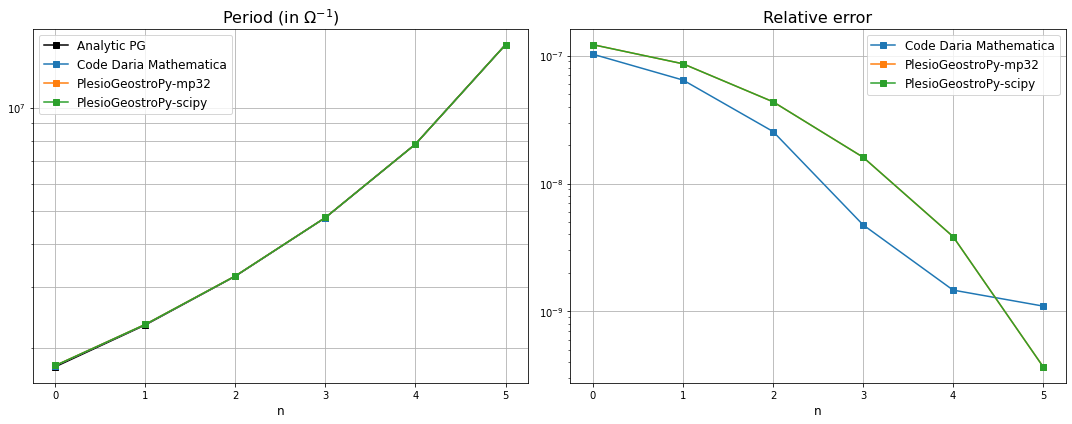

In [66]:
df_compare = df_west
compare_ref = "Analytic PG"
save_name = "./out/imgs/err_comparison_west__PG"
override = True

df_compare_err = pd.DataFrame()
for idx, srcname in enumerate(src_names):
    df_compare_err[srcname] = np.abs(df_compare[compare_ref] - df_compare[srcname])/np.abs(df_east[compare_ref])
display(df_compare_err.transpose().style.format(formatter=lambda x: "{:.3e}".format(x)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax = axes[0]
ax.semilogy(np.arange(6), 2*np.pi*1e+4/np.abs(np.imag(df_compare[compare_ref])), 'ks-', label=compare_ref)
for idx, srcname in enumerate(src_names):
    ax.semilogy(np.arange(6), 2*np.pi*1e+4/np.abs(np.imag(df_compare[srcname])), 's-', label=srcname)
ax.grid(which="both")
ax.legend(fontsize=12)
ax.set_xlabel("n", fontsize=12)
ax.set_title("Period (in $\Omega^{-1}$)", fontsize=16)

ax = axes[1]
for idx, srcname in enumerate(src_names):
    ax.semilogy(np.arange(6), df_compare_err[srcname], 's-', label=srcname)
ax.grid(which="major")
ax.legend(fontsize=12)
ax.set_xlabel("n", fontsize=12)
ax.set_title("Relative error", fontsize=16)

plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.pdf') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.pdf', format="pdf", dpi=150, bbox_inches="tight")
plt.show()